In [1]:
import keras
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.models import model_from_json
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from keras.callbacks import ModelCheckpoint
from skimage.transform import resize
from skimage.io import imsave

session = keras.backend.get_session()

print("Python version",sys.version)
print ("keras version", keras.__version__)
print ("tensorflow version", tf.__version__)
print ("numpy version", np.__version__)
print("Eager mode", tf.executing_eagerly())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Python version 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
keras version 2.8.0
tensorflow version 2.8.0
numpy version 1.22.2
Eager mode True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1345624870515634904
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1172860329802649007
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


In [2]:
# Get images
X = []
for filename in os.listdir('../data/Train/'):
    X.append(img_to_array(load_img('../data/Train/'+filename)))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

tf.compat.v1.disable_eager_execution()
# print("Eager mode", tf.executing_eagerly())

#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.compat.v1.get_default_graph()

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
# load json and create model
json_file = open('model_colorme.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

optz = tf.optimizers.Adam(lr=0.00001)
#optz = tf.optimizers.rmsprop(lr=0.00001)
model.compile(optimizer=optz, loss='mse', metrics=['acc'])
model.summary()

# load weights into new model
model.load_weights("colorme_weight5k_4.h5",by_name=True)
print("Loaded weights from previous run")

Model: "Colorizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_323 (Conv2D)            (None, 128, 128, 64  640         ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_324 (Conv2D)            (None, 128, 128, 12  73856       ['conv2d_323[0][0]']             
                                8)                                                        

c:\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Loaded weights from previous run


embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.summary()

In [4]:
filepath="weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [5]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with session.as_default():
        with inception.graph.as_default():
            embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 40

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)

In [6]:
#Train model
history = model.fit(image_a_b_gen(batch_size), epochs=10, steps_per_epoch=125, callbacks=callbacks_list, verbose=1)

# Save model
model_json = model.to_json()
with open("model_colorme.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("colorme_weight5k_5.h5")

Epoch 1/10


c:\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


125/125 [==============================] - ETA: 0s - batch: 62.0000 - size: 40.0000 - loss: 0.0060 - acc: 0.6315
Epoch 1: acc improved from -inf to 0.63147, saving model to weights-improvement-01-0.01.hdf5
125/125 [==============================] - 475s 3s/step - batch: 62.0000 - size: 40.0000 - loss: 0.0060 - acc: 0.6315
Epoch 2/10
125/125 [==============================] - ETA: 0s - batch: 62.0000 - size: 40.0000 - loss: 0.0059 - acc: 0.6326
Epoch 2: acc improved from 0.63147 to 0.63264, saving model to weights-improvement-02-0.01.hdf5
125/125 [==============================] - 389s 3s/step - batch: 62.0000 - size: 40.0000 - loss: 0.0059 - acc: 0.6326
Epoch 3/10
125/125 [==============================] - ETA: 0s - batch: 62.0000 - size: 40.0000 - loss: 0.0059 - acc: 0.6339
Epoch 3: acc improved from 0.63264 to 0.63386, saving model to weights-improvement-03-0.01.hdf5
125/125 [==============================] - 389s 3s/step - batch: 62.0000 - size: 40.0000 - loss: 0.0059 - acc: 0.6339


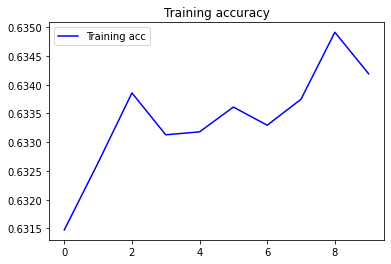

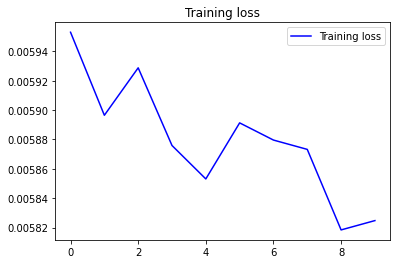

In [7]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [8]:
color_me = []
for filename in os.listdir('../data/Test/'):
    color_me.append(img_to_array(load_img('../data/Test/'+filename)))
color_me = np.array(color_me, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("result/img_"+str(i)+".png", lab2rgb(cur))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0